Dynamic Programming --- Assignment

Since $C = H^\alpha L$ and $H' = (1-\delta)H + 1 - L$ we can rewrite the problem under the  Function equation representation:

$$
V(H) = max_{H' \in \Gamma(H)} (U(H,H\\') + \beta V(H'')
$$

with $\Gamma(H) = [(1-\delta)H, (1-\delta)H + 1]$, and with $U(C)=U(H^\alpha [(1-\delta)H +1-H'])$


In [1]:
#==============================================================================
# Dynamic Programming - Project
# QUESTIONS 1, 2
#==============================================================================

import os
import numpy as np
from scipy.optimize import fminbound
import matplotlib.pyplot as plt
import pandas as pd


def bellman_operator(w, grid, β, delta, u, f, Tw=None, compute_policy=0):
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        σ = np.empty_like(w)
        c_opt = np.empty_like(w)
        l_opt = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + β E w(f(y  - c) z)} == #
    for i, h in enumerate(grid):
        def objective(l, h=h):
            hprime = (1 - delta)*h + 1 - l
            return - u(f(h, l)) - (β * w_func(hprime))
        l_star = fminbound(objective, 0, 1)
            
        if compute_policy:
            σ[i] = (1-delta) * h + 1 - l_star #h_(t+1) as a function of h_t
            c_opt[i] = f(h,l_star)
            l_opt[i] = l_star
        Tw[i] = - objective(l_star)
        

    if compute_policy:
        return Tw, σ, c_opt, l_opt
    else:
        return Tw



def solve_optgrowth(initial_w, grid, β, delta, u, f, tol=1e-4, max_iter=500):

    w = initial_w  # Set initial condition
    error = tol + 1
    i = 0

    # == Create storage array for bellman_operator. Reduces  memory
    # allocation and speeds code up == #
    Tw = np.empty(len(grid))

    # Iterate to find solution
    while error > tol and i < max_iter:
        w_new = bellman_operator(w,
                                 grid,
                                 β,
                                 delta,
                                 u,
                                 f,
                                 Tw)
        error = np.max(np.abs(w_new - w))
        w[:] = w_new
        i += 1
        print("Iteration "+str(i)+'\n Error is '+str(error)+'\n') if i % 50 == 0 or error < tol else None

        
    # Computes policy
    w, policy, c_opt, l_opt = bellman_operator(w,
                             grid,
                             β,
                             delta,
                             u,
                             f,
                             Tw,
                             compute_policy=1)
 
    return [w, policy, c_opt, l_opt]



class CES_OG:
    """
    Constant elasticity of substitution optimal growth model so that

        c = f(h,l) = h^α * l


    The class holds parameters and true value and policy functions.
    """

    def __init__(self, α=0.4, β=0.9, sigma=0.9, delta=0.05):

        self.α, self.β, self.sigma, self.delta = α, β, sigma, delta

    def u(self, c):
        " Utility "
        return (c**(1-self.sigma))/(1-self.sigma)

    def f(self, h,l):
        " consumption function.  "
        return h**self.α * l
    

In [2]:

# Creation of the model
ces = CES_OG()
# == Unpack parameters / functions for convenience == #
α, β, sigma, delta = ces.α, ces.β, ces.sigma, ces.delta


### Setup of the grid
grid_max = 5         # Largest grid point
grid_size = 4000     # Number of grid points
grid = np.linspace(1e-5, grid_max, grid_size)

# Initial conditions and shocks
initial_w = 5 * np.log(grid)


# Computation of the value function
solve = solve_optgrowth(initial_w, grid, β, delta, u=ces.u,
                               f=ces.f, tol=1e-4, max_iter=500)

value_approx = solve[0]
policy_function = solve[1]
c_opt = solve[2]
l_opt = solve[3]

Iteration 50
 Error is 0.05593634511826906

Iteration 100
 Error is 0.0002882835158999342

Iteration 111
 Error is 9.046656832367717e-05



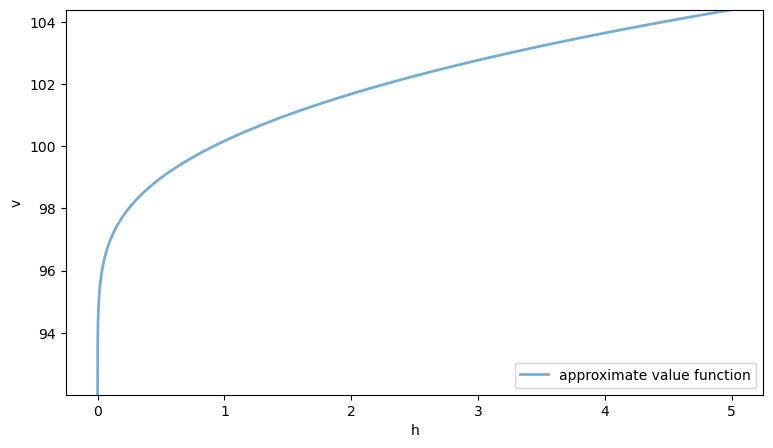

In [9]:

#==============================================================================
# Plotting value function
#==============================================================================

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(min(value_approx), max(value_approx))
ax.plot(grid, value_approx, lw=2, alpha=0.6, label='approximate value function')
ax.set_xlabel('h')
ax.set_ylabel('v')
ax.legend(loc='lower right')
plt.show()

We obtain a value function that is concave and increasing. 

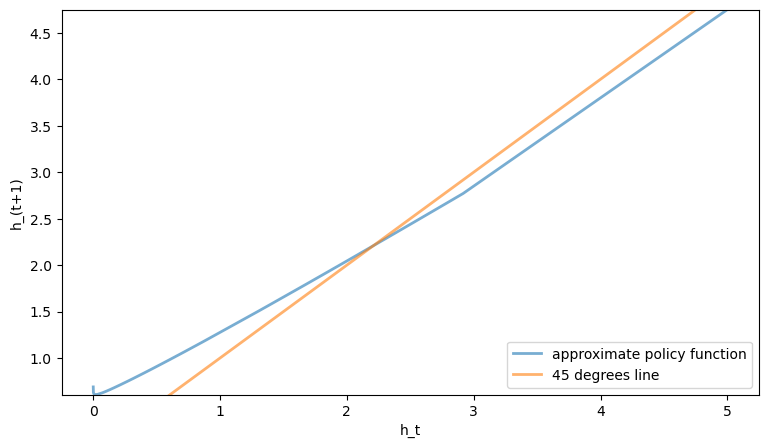

In [3]:

#==============================================================================
# Plotting Policy function
#==============================================================================

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(min(policy_function), max(policy_function))
ax.plot(grid, policy_function, lw=2, alpha=0.6, label='approximate policy function')

# 45° line
ax.plot(grid, grid, lw=2, alpha=0.6, label='45 degrees line')

ax.set_xlabel('h_t')
ax.set_ylabel('h_(t+1)')
ax.legend(loc='lower right')
plt.show()

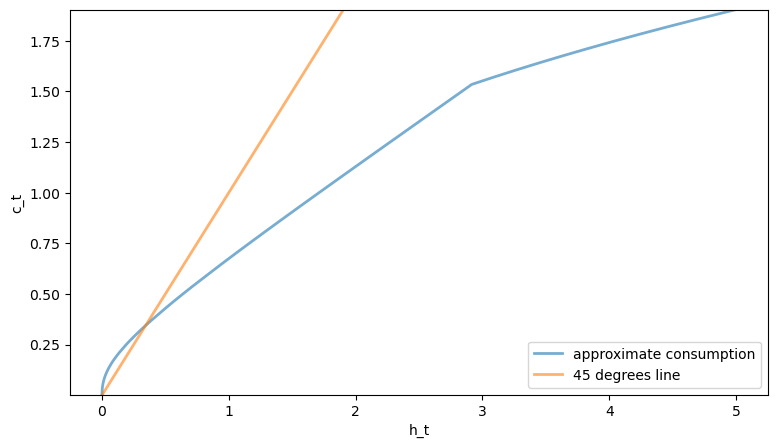

In [4]:

#==============================================================================
# Plotting Consumption
#==============================================================================

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(min(c_opt), max(c_opt))
ax.plot(grid, c_opt, lw=2, alpha=0.6, label='approximate consumption')

# 45° line
ax.plot(grid, grid, lw=2, alpha=0.6, label='45 degrees line')

ax.set_xlabel('h_t')
ax.set_ylabel('c_t')
ax.legend(loc='lower right')
plt.show()


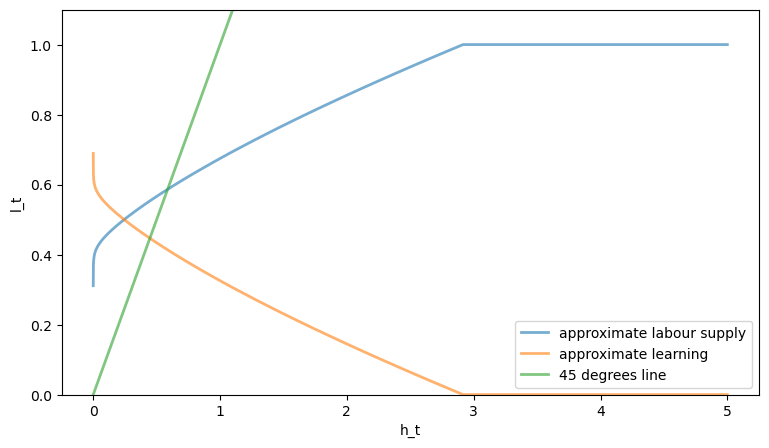

In [5]:

#==============================================================================
# Plotting labour supply
#==============================================================================

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(0,1.1)
ax.plot(grid, l_opt, lw=2, alpha=0.6, label='approximate labour supply')
ax.plot(grid, (1-l_opt), lw=2, alpha=0.6, label='approximate learning')

# 45° line
ax.plot(grid, grid, lw=2, alpha=0.6, label='45 degrees line')

ax.set_xlabel('h_t')
ax.set_ylabel('l_t')
ax.legend(loc='lower right')
plt.show()

From the plot of the policy function $H_{t+1}$ as function of $H_t$ we can observe the steady state level of human capital, which is at the intersection of the policy function and the 45 degree line.

Below we retrieve the steady state value of human capital, and compute from it the steady states of consumption, labour supply. To do so we derive analytically the steady state.  

In [12]:


#==============================================================================
# Finding steady state
#==============================================================================

# Creation of the model
ces = CES_OG()
# == Unpack parameters / functions for convenience == #
α, β, sigma, delta = ces.α, ces.β, ces.sigma, ces.delta

ss = np.absolute(grid - policy_function)
ss = pd.DataFrame(ss)
index_min = ss.idxmin() 
ss_h = policy_function[index_min] # SS of h
ss_l = 1-delta*ss_h # l analytical SS
ss_c = ces.f(ss_h,ss_l) # c analytical SS
print(ss_h, ss_l, ss_c)

[2.20805768] [0.88959712] [1.22123019]


In [15]:
#==============================================================================
# Dynamic Programming - Project
# QUESTIONS 3
#==============================================================================

def iterative_policy_function(w, policy, grid, β, delta, u, f, updated_w = None):
    w_func = lambda x: np.interp(x, grid, w)  # Interpolates value function
    if updated_w is None:
        updated_w = np.empty_like(w)

    for i, h in enumerate(grid):
        # Compute next period's human capital
        hprime = (1 - delta)*h + 1 - policy[i]
        # Compute the updated value using the Bellman equation
        updated_w[i] = u(f(h, policy[i])) + (β * w_func(hprime))
    return updated_w


def solve_optimal_policy(initial_w, policy, grid, β, delta, u, f, tol=1e-4, max_iter=500):
    w = np.empty(len(grid))
    w[:] = initial_w  # Set initial condition
    error = tol + 1
    i = 0

    # == Create storage array for bellman_operator. Reduces  memory allocation and speeds code up == #
    updated_w = np.empty(len(grid))

    # Iterate to find solution
    while error > tol and i < max_iter:
        w_new = iterative_policy_function(w, policy, grid, β, delta, u, f, updated_w)

        error = np.max(np.abs(w_new - w))
        w[:] = w_new
        i += 1
        print("Iteration "+str(i)+'\n Error is '+str(error)+'\n') if i % 50 == 0 or error < tol else None

    return [w]


class CES_OG:
    """
    Constant elasticity of substitution optimal growth model so that

        c = f(h,l) = h^α * l


    The class holds parameters and true value and policy functions.
    """

    def __init__(self, α=0.4, β=0.9, sigma=0.9, delta=0.05):

        self.α, self.β, self.sigma, self.delta = α, β, sigma, delta

    def u(self, c):
        " Utility "
        return (c**(1-self.sigma))/(1-self.sigma)

    def f(self, h,l):
        " consumption function.  "
        return h**self.α * l
    

In [18]:
  
# Creation of the model
ces = CES_OG()
# == Unpack parameters / functions for convenience == #
α, β, sigma, delta = ces.α, ces.β, ces.sigma, ces.delta


### Setup of the grid
grid_max = 5         # Largest grid point
grid_size = 4000     # Number of grid points
grid = np.linspace(1e-5, grid_max, grid_size)
arb_policy =  0.5*grid  # Arbitrary policy for labor allocation


# Initial guess for the value function
guess_w = ces.u(ces.f(grid, arb_policy))

# Computation of the value function
solve = solve_optimal_policy(guess_w, arb_policy, grid, β, delta, u=ces.u,
                               f=ces.f, tol=1e-4, max_iter=500)

value_approx = solve[0]

Iteration 50
 Error is 0.052284347693472455

Iteration 100
 Error is 0.00026946177493414325

Iteration 110
 Error is 9.395551137458824e-05



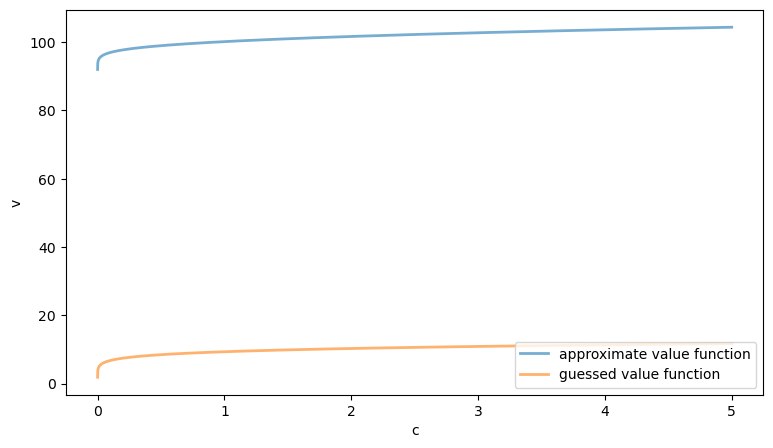

In [19]:

#==============================================================================
# Plotting value function
#==============================================================================

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(grid, value_approx, lw=2, alpha=0.6, label='approximate value function')
ax.plot(grid, guess_w, lw=2, alpha=0.6, label='guessed value function')
ax.set_xlabel('c')  # i think this is wrong: grid = human capital is on the x-axis
ax.set_ylabel('v')
ax.legend(loc='lower right')
plt.show()

In [21]:
#==============================================================================
# Dynamic Programming - Project
# QUESTIONS 4
#==============================================================================

# Define e-greedy policy improvement
def improve_policy_epsilon_greedy(w, grid, β, delta, u, f, epsilon=0.01):
    """

    Returns:
        Tw: Updated value function.
        Tpolicy: Updated policy function.
    """
    w_func = lambda x: np.interp(x, grid, w)
    Tw = np.empty_like(w)
    l_opt = np.empty_like(w)

    for i, h in enumerate(grid):
        def objective(l, h=h):
            hprime = (1 - delta)*h + 1 - l
            return - u(f(h, l)) - (β * w_func(hprime))
        l_star = fminbound(objective, 0, 1)

        if np.random.rand() < epsilon:  # Exploration
            l_star = np.random.uniform(1e-10, 1)  # Random labor allocation
        else:  # Exploitation
            l_star = fminbound(objective, 0, 1)  # Find optimal labor allocation

        l_opt[i] = l_star
        Tw[i] = -objective(l_star)  # Reverse sign to get max value

    return Tw, l_opt


# Iterative solution with e-greedy policy improvement
def solve_with_epsilon_greedy(initial_policy, grid, β, delta, u, f, epsilon=0.01, tol=1e-5, max_iter=100):
    """
    Solve the model using e-greedy policy improvement.
    """
    policy = initial_policy
    value_function = np.zeros_like(grid)
    w_history = []  # To store value functions at each iteration
    error = tol + 1
    iteration = 0

    while error > tol and iteration < max_iter:
        # Evaluate the value function for the current policy
        new_value_function = iterative_policy_function(
            value_function, policy, grid, β, delta, u, f
        )

        # Improve the policy using e-greedy exploration
        new_value_function, new_policy = improve_policy_epsilon_greedy(
            new_value_function, grid, β, delta, u, f, epsilon
        )

        # Check convergence
        error = np.max(np.abs(new_value_function - value_function))
        value_function[:] = new_value_function
        policy[:] = new_policy
        w_history.append(value_function.copy())  # Save the value function for plotting
        iteration += 1

        print(f"Iteration {iteration}, Error: {error}")  if iteration % 1 == 0 or error < tol else None

    return value_function, policy, w_history


In [22]:

### Setup of the grid
grid_max = 5         # Largest grid point
grid_size = 4000     # Number of grid points
grid = np.linspace(1e-5, grid_max, grid_size)
arb_policy = 0.5 * grid  # Arbitrary policy for labor allocation

# Solve using e-greedy policy improvement
value_function, optimal_policy, w_history = solve_with_epsilon_greedy(
    arb_policy, grid, β, delta, ces.u, ces.f, epsilon=0.01
)



Iteration 1, Error: 21.109179419868756
Iteration 2, Error: 19.35220613348416
Iteration 3, Error: 16.235250553136574
Iteration 4, Error: 13.743601822291716
Iteration 5, Error: 10.83855237521405
Iteration 6, Error: 8.927249770647002
Iteration 7, Error: 8.877880613106981
Iteration 8, Error: 7.554246616327887
Iteration 9, Error: 6.449569618481576
Iteration 10, Error: 4.0792368360683895
Iteration 11, Error: 4.99817931818508
Iteration 12, Error: 4.593642740279606
Iteration 13, Error: 4.788773155695679
Iteration 14, Error: 7.609074498067969
Iteration 15, Error: 3.7377805242968805
Iteration 16, Error: 2.428175312899981
Iteration 17, Error: 2.8148151155374137
Iteration 18, Error: 2.6092210996602034
Iteration 19, Error: 2.707436682729991
Iteration 20, Error: 3.437360176192101
Iteration 21, Error: 4.074510466238962
Iteration 22, Error: 4.938495487383591
Iteration 23, Error: 5.356396367404528
Iteration 24, Error: 2.3472936687157784
Iteration 25, Error: 2.5238494633146047
Iteration 26, Error: 2.903

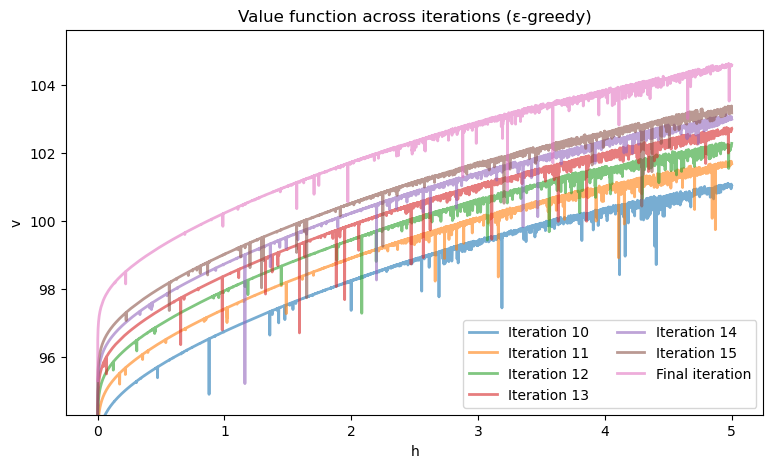

In [36]:

# Plot the value functions across iterations
w_matrix = np.array(w_history)
fig, ax = plt.subplots(figsize=(9, 5))

# Set y-axis limits to span the range of value functions
ax.set_ylim(min(w_matrix[-1]) - 1, max(w_matrix[-1]) + 1)

# Plot each value function from the iterations
for i, w_iter in enumerate(w_matrix[15:21,:]):
    ax.plot(grid, w_iter, lw=2, alpha=0.6, label=f'Iteration {i+10}' if i < 10 else None)

ax.plot(grid, w_matrix[-1,:], lw=2, alpha=0.6, label=f'Final iteration' if i < 10 else None)

# Label the axes
ax.set_xlabel('h')
ax.set_ylabel('v')
ax.legend(loc='lower right', ncol=2)

# Display the plot
plt.title('Value function across iterations (ε-greedy)')
plt.show()


We see that the exploration steps more often lead to lower values of the value function. In this case, exploring is not useful since we know the optimal policy function. 

We retrieve the value function obtained in questions 1 and 3.

OPTIONAL QUESTION

Below we use neural network to approximate the response of the variables to a shock to human capital. 

We derive the euler equation:

$$
H_t^\alpha U(C_t)' = \beta  U(C_{t+1})' [(\alpha+1)(1-\delta)]H_{t+1}^\alpha + \alpha H_{t+1}^{\alpha-1} (1-H_{t+2})]
$$

from which we can derive the analatycal steady state of $H, L, C$, by setting $H_{t}  = H_{t+1}$ and solving.

We check that the analytical steady state values we obtain are very close to the numerical values we obtain in question 1, which indicates the NN approximates well the solution.

We account for the slackness condition in the euler equation by adding Kuhn-Tucker multipliers to the Euler equation. Indeed, the Lagrangian of the problem we solve writes:

$$
L = ... - \mu^1_t (0-l_t) - \mu^2_t (l_t - 1)
$$
because we must have $L_t >= 0$ and $L_t <= 1$, thus the Euler is changed to:

$$
H_t^\alpha U(C_t)' + \mu^1_t + \mu^2_t = \beta  U(C_{t+1})' [(\alpha+1)(1-\delta)]H_{t+1}^\alpha + \alpha H_{t+1}^{\alpha-1} (1-H_{t+2})]
$$

These KKT multiplier are active (are positive) when $L_t$ falls outside its bounds, and we impose a penalty factor equal to 2. For instance, if $L_t = 1.1$, we add  $(L_t-1) *2 = 0.1 * 2 = \mu^2_t$ to the Euler equation. 

We compare our IRFs to an unconstrained model where labour is allowed to take any value. Our procedure manages to keep labour supply below one and above zero for all kinds of shocks. For instance, the case $H_0=5$ is illustrated below.

In [1]:


#==============================================================================
# Dynamic Programming - Project
# QUESTION OPTIONAL
#==============================================================================


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsummary
from d2l import torch as d2l


fontsize= 14
ticksize = 14
figsize = (12, 4.5)
params = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
#plt.rcParams.update(params)


class Params(d2l.HyperParameters):
    def __init__(self,
                 alpha = 0.4,
                 beta = 0.9,
                 delta = 0.05,
                 h_0 = 5,
                 sigma = 0.9,
                ):
        self.save_hyperparameters()
        
        

def f(h, l):
    alpha = Params().alpha
    return h**alpha * l

def u_prime(c):
    sigma = Params().sigma
    out = c.pow(-sigma)
    return out



class SS: #steady state
    def __init__(self):
        self.delta = Params().delta
        self.beta = Params().beta
        self.alpha = Params().alpha
        self.h_ss = (self.alpha*self.beta)/(
            (1+self.alpha*self.beta)-self.beta*(1+self.alpha)*(1-self.delta)
            )
        self.l_ss = 1-self.delta*self.h_ss
        self.c_ss = f(self.h_ss,self.l_ss)
        

class Grid_data(d2l.HyperParameters):
    def __init__(self,
                 max_T = 32,
                 batch_size = 8
                 ):
        self.save_hyperparameters()
        self.time_range = torch.arange(0.0, self.max_T , 1.0)
        self.grid = self.time_range.unsqueeze(dim = 1)
        
        
        

class Data_label(Dataset):

    def __init__(self,data):
        self.time = data
        self.n_samples = self.time.shape[0]

    def __getitem__(self,index):
            return self.time[index]

    def __len__(self):
        return self.n_samples
    

train_data = Grid_data().grid
train_labeled = Data_label(train_data)
train = DataLoader(dataset = train_labeled, batch_size = 8 , shuffle = True )



class NN(nn.Module, d2l.HyperParameters):
    def __init__(self,
                 dim_hidden = 128,
                layers = 4,
                hidden_bias = True):
        super().__init__()
        self.save_hyperparameters()

        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.Tanh())

        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.Tanh())

        module.append(nn.Linear(self.dim_hidden,2))
        module.append(nn.Softplus(beta = 1.0)) #The softplus layer ensures c>0,k>0

        self.q = nn.Sequential(*module)

   # def forward(self, x):
    #        out = self.q(x) # first element is consumption, the second element is capital
     #       l_t = torch.clamp(out[:, [0]], 0, 1)  # Clamp l_t to [0, 1]
      #      h_t = F.softplus(out[:, [1]])
       #     return torch.cat((l_t, h_t), dim=1)

    def forward(self, x):
        out = self.q(x) # first element is consumption, the second element is capital
        return  out
    
    
    

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
        
          
### TEST WITHOUT SLACKNESS CONDITION ON LABOUR 


qq_hat= NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(qq_hat.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)


print(qq_hat)

# Optimization of the network’s weights.

delta = Params().delta
beta = Params().beta
alpha = Params().alpha
h_0 = Params().h_0

num_epochs = 1001


# Torchsummary provides a more readable summary of the neural network
torchsummary.summary(qq_hat, input_size=(1,))


for epoch in range(num_epochs):
    for i, time in enumerate(train):
        time_zero = torch.zeros([1,1])
        time_next = time+1
        time_2next = time_next+1
        l_t = qq_hat(time)[:,[0]]
        h_t = qq_hat(time)[:,[1]]
        l_tp1 = qq_hat(time_next)[:,[0]]
        h_tp1 = qq_hat(time_next)[:,[1]]
        h_tp2 = qq_hat(time_2next)[:,[1]]
        h_t0 = qq_hat(time_zero)[0,1]

        res_1 = h_tp1 - (1-delta)*h_t - (1-l_t) # Law of motion of human capital
        res_2 = h_t**(alpha)*u_prime(f(h_t,l_t))/u_prime(f(h_tp1,l_tp1)) - beta*(
            (1+alpha)*(1-delta)*h_tp1**(alpha) + alpha*h_tp1**(alpha-1)*(1-h_tp2)
            ) # euler equation
        res_3 = h_t0-h_0 #Initial Condition
            
        # imposing slackness condition on euler equation
        loss_1 = res_1.pow(2).mean()
        loss_2 = res_2.pow(2).mean()
        loss_3 = res_3.pow(2).mean() 
            
        loss = 0.1*loss_1+0.8*loss_2+0.1*loss_3

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    scheduler.step()

    if epoch == 0:
         print('epoch' , ',' , 'loss' , ',', 'loss_bc' , ',' , 'loss_euler' , ',' , 'loss_initial' ,
               ',', 'lr_rate')
    if epoch % 100 == 0:
          print(epoch,',',"{:.2e}".format(loss.detach().numpy()),',',
                "{:.2e}".format(loss_1.detach().numpy()) , ',' , "{:.2e}".format(loss_2.detach().numpy())
               , ',' , "{:.2e}".format(loss_3.detach().numpy()), ',', "{:.2e}".format(get_lr(optimizer)) )
      
          
### TEST SLACKNESS PARAMETER IN EULER
qqq_hat= NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(qqq_hat.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)


print(qq_hat)

# Optimization of the network’s weights.

delta = Params().delta
beta = Params().beta
alpha = Params().alpha
h_0 = Params().h_0

num_epochs = 1001


# Torchsummary provides a more readable summary of the neural network
torchsummary.summary(qq_hat, input_size=(1,))


for epoch in range(num_epochs):
    for i, time in enumerate(train):
        time_zero = torch.zeros([1,1])
        time_next = time+1
        time_2next = time_next+1
        l_t = qqq_hat(time)[:,[0]]
        h_t = qqq_hat(time)[:,[1]]
        l_tp1 = qqq_hat(time_next)[:,[0]]
        h_tp1 = qqq_hat(time_next)[:,[1]]
        h_tp2 = qqq_hat(time_2next)[:,[1]]
        h_t0 = qqq_hat(time_zero)[0,1]

       
        # Slackness conditions 
        slack_penalty = torch.zeros_like(l_t) # lagrange multiplier is non-zero when labour outside bounds
        
        # add the difference between l_t and bounds to multiplier 
        slack_penalty += torch.clamp(l_t - 1, min=0)  # when l_t > 1
        slack_penalty += torch.clamp(-l_t, min=0)     # when l_t < 0
        
        # Add penalties for l_tp1
        slack_penalty += torch.clamp(l_tp1 - 1, min=0)  # when l_tp1 > 1
        slack_penalty += torch.clamp(-l_tp1, min=0)     # when l_tp1 < 0
        
        slack_penalty = 2*slack_penalty # penalise by factor 2
        
        res_1 = h_tp1 - (1-delta)*h_t - (1-l_t) # Law of motion of human capital
        res_2 = h_t**(alpha)*u_prime(f(h_t,l_t)) + slack_penalty - beta*u_prime(f(h_tp1,l_tp1))*(
            (1+alpha)*(1-delta)*h_tp1**(alpha) + alpha*h_tp1**(alpha-1)*(1-h_tp2)
            ) # euler equation
        res_3 = h_t0-h_0 #Initial Condition
            
        # imposing slackness condition on euler equation
        loss_1 = res_1.pow(2).mean()
        loss_2 = res_2.pow(2).mean() 
        loss_3 = res_3.pow(2).mean() 
            
            
        loss = 0.1*loss_1+0.8*loss_2+0.1*loss_3

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    scheduler.step()

    if epoch == 0:
         print('epoch' , ',' , 'loss' , ',', 'loss_bc' , ',' , 'loss_euler' , ',' , 'loss_initial' ,
               ',', 'lr_rate')
    if epoch % 100 == 0:
          print(epoch,',',"{:.2e}".format(loss.detach().numpy()),',',
                "{:.2e}".format(loss_1.detach().numpy()) , ',' , "{:.2e}".format(loss_2.detach().numpy())
               , ',' , "{:.2e}".format(loss_3.detach().numpy()), ',', "{:.2e}".format(get_lr(optimizer)) )
      


NN(
  (q): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=2, bias=True)
    (9): Softplus(beta=1.0, threshold=20.0)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             256
              Tanh-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              Tanh-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
              Tanh-6                  [-1, 128]               0
            Linear-7                  [-1, 1

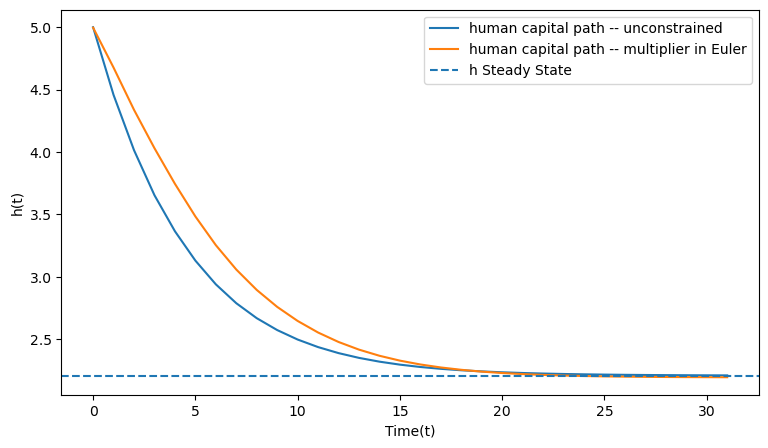

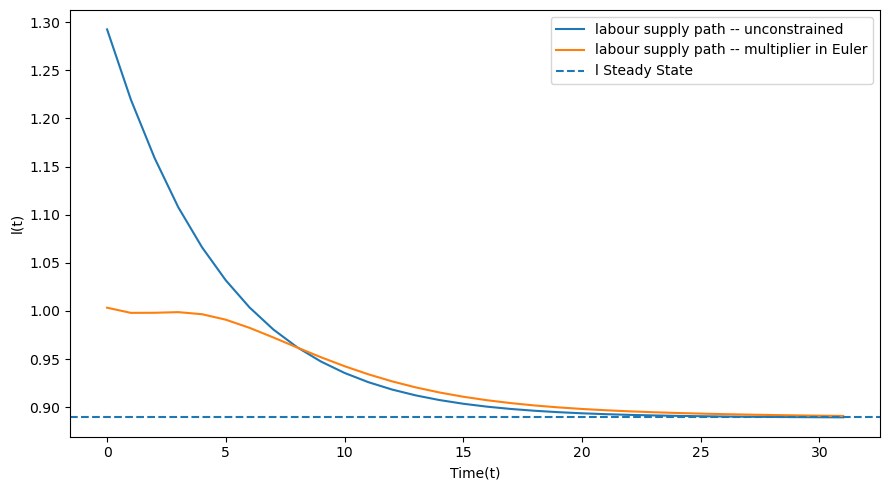

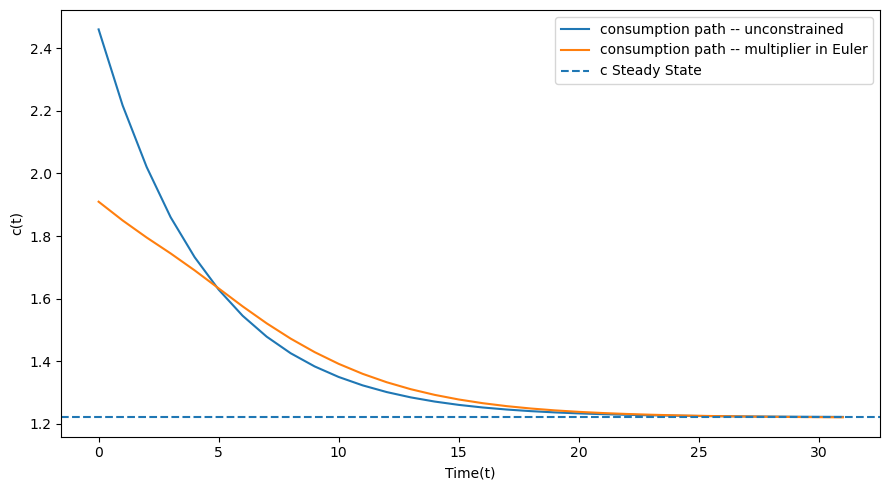

In [3]:

# Euler with slackness condition on labour         
time_test = Grid_data().grid

# without
l_hat_path2 = qq_hat(time_test)[:,[0]].detach()
h_hat_path2 = qq_hat(time_test)[:,[1]].detach()
c_hat_path2 = f(h_hat_path2, l_hat_path2)
# Slackness in Euler
l_hat_path3 = qqq_hat(time_test)[:,[0]].detach()
h_hat_path3 = qqq_hat(time_test)[:,[1]].detach()
c_hat_path3 = f(h_hat_path3, l_hat_path3)


plt.figure(figsize=(9, 5)) 
plt.plot(time_test, h_hat_path2, label=r"human capital path -- unconstrained")
plt.plot(time_test, h_hat_path3, label=r"human capital path -- multiplier in Euler")
plt.axhline(y=SS().h_ss, linestyle='--', label="h Steady State")
plt.ylabel(r"h(t)")
plt.xlabel(r"Time(t)")
#plt.ylim([Params().h_0 - 0.1, SS().h_ss + 0.1])
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(9, 5))  # Set figure size to 9 by 5
plt.plot(time_test,l_hat_path2,label= r"labour supply path -- unconstrained")
plt.plot(time_test,l_hat_path3,label= r"labour supply path -- multiplier in Euler")
plt.axhline(y=SS().l_ss, linestyle='--',label="l Steady State")
plt.xlabel(r"Time(t)")
plt.ylabel(r"l(t)")
#plt.ylim([l_hat_path[0]-0.1,SS().l_ss+0.1 ])
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(9, 5))  # Set figure size to 9 by 5
plt.plot(time_test,c_hat_path2,label= r"consumption path -- unconstrained")
plt.plot(time_test,c_hat_path3,label= r"consumption path -- multiplier in Euler")
plt.axhline(y=SS().c_ss, linestyle='--',label="c Steady State")
plt.xlabel(r"Time(t)")
plt.ylabel(r"c(t)")
#plt.ylim([c_hat_path[0]-0.1,SS().c_ss+0.1 ])
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()


We  observe some compensation effects taking place, such that even when the agent is constrained relative to what is optimal (in an unconstrained world), her labour supply remains for some time around 1, before converging to steady state. 

Human capital does not follow the exact same paths when labour is contrained and not. $H_t$ decreases at a faster pace in the unconstrained world. This is due to the fact that labour supply cloes but not exactly at one in the early periods after the shock, feeding human capital accumulation. The rest of the convergence to SS is driven by depreciation rate, which is the same across both experiments. Consumption is lower when the individual cannot work more than 1, as can be expected, and also stays high for longer. This can be explained by the fact that the agents wants to reap all benefits from the human accumulation shock. The same reasoning can be applied to explain why labour supply stays high for longer when we apply the constraints.

We also test the solution method to a variety of shocks, and as expected when the constraints on labour supply are not binding, the responses and convergence paths are the same. 